# **Trabajo Práctico de Análisis de Sentimientos**

# Cargamos Librerias

In [1]:
import nltk

#Descargar la lista de stopwords
#nltk.download('stopwords')

In [2]:
 #pip install textacy

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

from textacy import preprocessing

from google.colab import drive # para cargar dataset
drive.mount("/content/drive")
data_path = "/content/drive/MyDrive/.NOTEBOOK/"


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc


Mounted at /content/drive


# Módulo de Procesamiento de Texto

In [4]:
"""Text preprocessing module."""

STOPWORDS_SET = set(stopwords.words('english'))
EMOJI_PATTERN = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)


textacy_preproc = preprocessing.make_pipeline(
        preprocessing.normalize.whitespace,
        preprocessing.remove.accents,
        preprocessing.remove.brackets,
        preprocessing.remove.html_tags,
        preprocessing.replace.currency_symbols,
        preprocessing.replace.emails,
        preprocessing.replace.emojis,
        preprocessing.replace.numbers,
        preprocessing.replace.phone_numbers,
        preprocessing.replace.urls,
        preprocessing.replace.user_handles
)


def remove_stopwords(text):
    """Remove stop words from list of tokenized words."""
    new_words = [word for word in text.split() if word not in STOPWORDS_SET]
    return ' '.join(new_words)

def remove_emoticons(text):
    """Remove emoticos."""
    return EMOJI_PATTERN.sub('', text)


def preprocess_text(text):
    """Preprocess text."""
    clean_text = ""
    clean_text = remove_emoticons(text.lower())
    clean_text = remove_stopwords(clean_text)

    clean_text = textacy_preproc(clean_text)

    return clean_text


PREPROCESS_VECTORIZED = np.vectorize(preprocess_text)


class TextPreProcess(BaseEstimator, TransformerMixin):
    """Text Transformer.

    Perform text preprocessing each text in a list.
    """
    def fit(self, X, y=None):
        """Fit method."""
        return self

    def transform(self, X):
        """Transform input X.

        Args:
            X: array of dictionaries.
        """
        transformed_list = PREPROCESS_VECTORIZED(X)
        return transformed_list

In [5]:
# Generamos variables para nombrar a cada modelo/transformador
LOGISTIC = 'logistic'
NAIVE = 'naive'
TFIDF = 'TFIDF'
COUNT_VEC = 'COUNT_VEC'


VECTORIZER_BY_NAME = {
    TFIDF: TfidfVectorizer(),
    COUNT_VEC: CountVectorizer()
}


MODELS_BY_NAME = {
    LOGISTIC: LogisticRegression(solver='sag', max_iter=10000),
    NAIVE: MultinomialNB()
}

In [6]:
def get_pipeline(model_name, vectorizer_name):
    """Retrieve sklearn pipeline."""
    pipeline = Pipeline([
        # normalize
        ('normalize', TextPreProcess()),
        # vectorizer
        ('feats', VECTORIZER_BY_NAME[vectorizer_name]),
        ('model', MODELS_BY_NAME[model_name])
    ])

    return pipeline

In [7]:
pipeline_logistic_TFIDF = get_pipeline('logistic', 'TFIDF')
pipeline_logistic_COUNT_VEC = get_pipeline('logistic', 'COUNT_VEC')
pipeline_naive_TFIDF = get_pipeline('naive', 'TFIDF')
pipeline_naive_COUNT_VEC = get_pipeline('naive', 'COUNT_VEC')

In [8]:
pipeline_logistic_TFIDF

Pipeline(steps=[('normalize', TextPreProcess()), ('feats', TfidfVectorizer()),
                ('model', LogisticRegression(max_iter=10000, solver='sag'))])

In [9]:
pipeline_logistic_COUNT_VEC

Pipeline(steps=[('normalize', TextPreProcess()), ('feats', CountVectorizer()),
                ('model', LogisticRegression(max_iter=10000, solver='sag'))])

In [10]:
pipeline_naive_TFIDF

Pipeline(steps=[('normalize', TextPreProcess()), ('feats', TfidfVectorizer()),
                ('model', MultinomialNB())])

In [11]:
pipeline_naive_COUNT_VEC

Pipeline(steps=[('normalize', TextPreProcess()), ('feats', CountVectorizer()),
                ('model', MultinomialNB())])

# Cargamos los Datos

In [12]:
df= pd.read_csv(data_path + 'yelp.csv')

df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


## Generando labels

Necesitamos generar dataset de entrenamiento.  
**Cómo conseguimos las clases?**:  Podemos usar las `stars` para dividir nuestro dataset

In [13]:
df.stars.value_counts()

4    3526
5    3337
3    1461
2     927
1     749
Name: stars, dtype: int64

In [14]:
positives = df.query("stars>=4")
negatives = df.query("stars<=2")
neutral = df.query("stars==3")

def get_label(star):
    label = ''
    if star >= 4:
        label = 'positive'
    elif star <= 2:
        label = 'negative'
    else:
        label = 'neutral'
    return label

df['label'] = df.stars.apply(get_label)

df['label'].value_counts()

positive    6863
negative    1676
neutral     1461
Name: label, dtype: int64

## Selección de Característica

In [15]:
df.columns

Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny', 'label'],
      dtype='object')

In [16]:
dataset = df[['text', 'label']]

# Entrenando modelo binario

In [17]:
binary_dataset = dataset.query("label!='neutral'")

from sklearn.model_selection import train_test_split

X = binary_dataset['text']
y= binary_dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=33, test_size=0.2, stratify=y)

print('Number of rows in the total set: {}'.format(binary_dataset.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))


Number of rows in the total set: 8539
Number of rows in the training set: 6831
Number of rows in the test set: 1708


# Entrenar Diferentes Pipelines



In [18]:
pipeline_logistic_TFIDF.fit(X_train, y_train)

Pipeline(steps=[('normalize', TextPreProcess()), ('feats', TfidfVectorizer()),
                ('model', LogisticRegression(max_iter=10000, solver='sag'))])

In [19]:
pipeline_logistic_COUNT_VEC.fit(X_train, y_train)

Pipeline(steps=[('normalize', TextPreProcess()), ('feats', CountVectorizer()),
                ('model', LogisticRegression(max_iter=10000, solver='sag'))])

In [20]:
pipeline_naive_TFIDF.fit(X_train, y_train)

Pipeline(steps=[('normalize', TextPreProcess()), ('feats', TfidfVectorizer()),
                ('model', MultinomialNB())])

In [21]:
pipeline_naive_COUNT_VEC.fit(X_train, y_train)

Pipeline(steps=[('normalize', TextPreProcess()), ('feats', CountVectorizer()),
                ('model', MultinomialNB())])

# Hacemos Predicción para Diferentes Pipelines

In [22]:
y_pred_pipeline_logistic_TFIDF = pipeline_logistic_TFIDF.predict(X_test)
y_pred_pipeline_logistic_COUNT_VEC = pipeline_logistic_COUNT_VEC.predict(X_test)
y_pred_pipeline_naive_TFIDF = pipeline_naive_TFIDF.predict(X_test)
y_pred_pipeline_naive_COUNT_VEC = pipeline_naive_COUNT_VEC.predict(X_test)


# Precisión

In [23]:

accuracy_pipeline_logistic_TFIDF = round(accuracy_score(y_test, y_pred_pipeline_logistic_TFIDF), 4)
accuracy_pipeline_logistic_COUNT_VEC = round(accuracy_score(y_test, y_pred_pipeline_logistic_COUNT_VEC), 4)
accuracy_pipeline_naive_TFIDF = round(accuracy_score(y_test, y_pred_pipeline_naive_TFIDF), 4)
accuracy_pipeline_naive_COUNT_VEC = round(accuracy_score(y_test, y_pred_pipeline_naive_COUNT_VEC,), 4)

recall_pipeline_logistic_TFID = round(recall_score(y_test, y_pred_pipeline_logistic_TFIDF, average="binary", pos_label='positive'), 4)
recall_pipeline_logistic_COUNT_VEC = round(recall_score(y_test, y_pred_pipeline_logistic_COUNT_VEC, average="binary", pos_label='positive'), 4)
recall_pipeline_naive_TFIDF = round(recall_score(y_test, y_pred_pipeline_naive_TFIDF, average="binary", pos_label='positive'), 4)
recall_pipeline_naive_COUNT_VEC = round(recall_score(y_test, y_pred_pipeline_naive_COUNT_VEC, average="binary", pos_label='positive'), 4)

precision_pipeline_logistic_TFID = round(precision_score(y_test, y_pred_pipeline_logistic_TFIDF, average="binary", pos_label='positive'), 4)
precision_pipeline_logistic_COUNT_VEC = round(precision_score(y_test, y_pred_pipeline_logistic_COUNT_VEC, average="binary", pos_label='positive'), 4)
precision_pipeline_naive_TFIDF = round(precision_score(y_test, y_pred_pipeline_naive_TFIDF, average="binary", pos_label='positive'), 4)
precision_pipeline_naive_COUNT_VEC = round(precision_score(y_test, y_pred_pipeline_naive_COUNT_VEC, average="binary", pos_label='positive'), 4)

f1_pipeline_logistic_TFID = round(f1_score(y_test, y_pred_pipeline_logistic_TFIDF, average="binary", pos_label='positive'), 4)
f1_pipeline_logistic_COUNT_VEC = round(f1_score(y_test, y_pred_pipeline_logistic_COUNT_VEC, average="binary", pos_label='positive'), 4)
f1_pipeline_naive_TFIDF = round(f1_score(y_test, y_pred_pipeline_naive_TFIDF, average="binary", pos_label='positive'), 4)
f1_pipeline_naive_COUNT_VEC = round(f1_score(y_test, y_pred_pipeline_naive_COUNT_VEC, average="binary", pos_label='positive'), 4)

# Devuelve Array, por eso le saco la media
vc_pipeline_logistic_TFID = round(cross_val_score(pipeline_logistic_TFIDF, X, y, cv=10).mean(), 4)
vc_pipeline_logistic_COUNT_VEC = round(cross_val_score(pipeline_logistic_COUNT_VEC, X, y, cv=10).mean(), 4)
vc_pipeline_naive_TFIDF = round(cross_val_score(pipeline_naive_TFIDF, X, y, cv=10).mean(), 4)
vc_pipeline_naive_COUNT_VEC = round(cross_val_score(pipeline_naive_COUNT_VEC, X, y, cv=10).mean(), 4)


# Crear el DataFrame con los nombres de columnas
column_names = ["PRECISION","pipeline_logistic_TFID", "pipeline_logistic_COUNT_VEC", "pipeline_naive_TFIDF", "pipeline_naive_COUNT_VEC"]

# Ejemplo de medidas de evaluación
data = [
    ["Precisión (Accuracy)", accuracy_pipeline_logistic_TFIDF, accuracy_pipeline_logistic_COUNT_VEC, accuracy_pipeline_naive_TFIDF, accuracy_pipeline_naive_COUNT_VEC],
    ["Exhaustividad (Recall)", recall_pipeline_logistic_TFID, recall_pipeline_logistic_COUNT_VEC, recall_pipeline_naive_TFIDF, recall_pipeline_naive_COUNT_VEC],
    ["Precisión (Score)", precision_pipeline_logistic_TFID, precision_pipeline_logistic_COUNT_VEC, precision_pipeline_naive_TFIDF, precision_pipeline_naive_COUNT_VEC],
    ["Puntuación F1 (F1 Score)", f1_pipeline_logistic_TFID, vc_pipeline_logistic_COUNT_VEC, f1_pipeline_naive_TFIDF, f1_pipeline_naive_COUNT_VEC],
    ["Validación Cruzada", vc_pipeline_logistic_TFID, vc_pipeline_logistic_COUNT_VEC, vc_pipeline_naive_TFIDF, vc_pipeline_naive_COUNT_VEC]
]

df = pd.DataFrame(data, columns=column_names)

# Imprimir el DataFrame
display(df)


,PRECISION,pipeline_logistic_TFID,pipeline_logistic_COUNT_VEC,pipeline_naive_TFIDF,pipeline_naive_COUNT_VEC
0,Precisión (Accuracy),0.8577,0.9104,0.8583,0.8893
1,Exhaustividad (Recall),0.9971,0.9614,0.9905,0.9731
2,Precisión (Score),0.8514,0.9296,0.8559,0.8978
3,Puntuación F1 (F1 Score),0.9185,0.9121,0.9183,0.9339
4,Validación Cruzada,0.8891,0.9121,0.8043,0.8938


# Matriz de Confusión

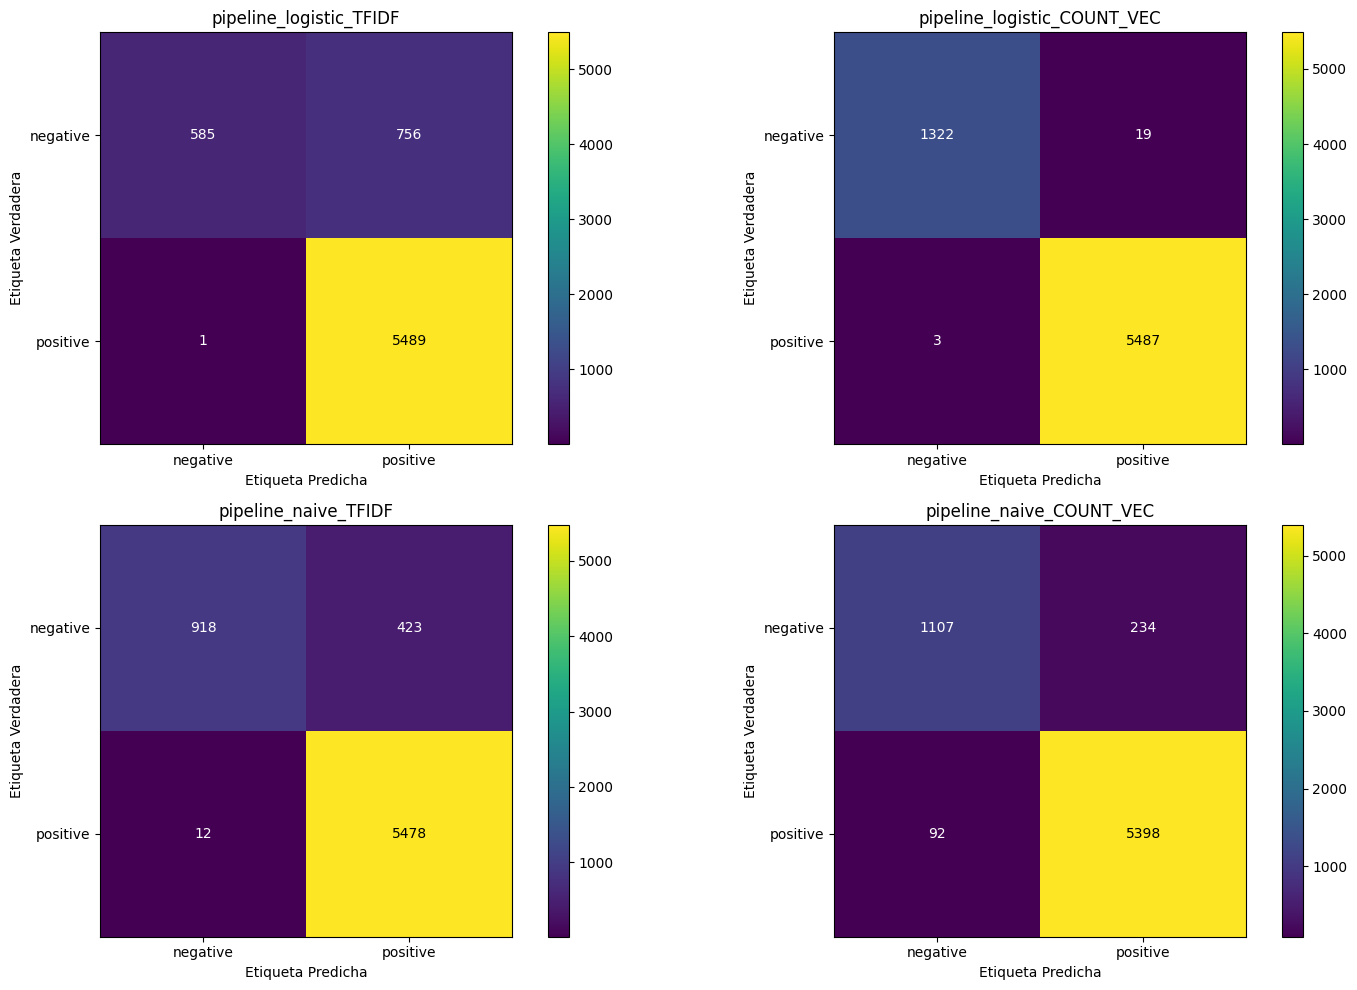

In [24]:

y_train_pred_pipeline_logistic_TFIDF = pipeline_logistic_TFIDF.predict(X_train)
y_train_pred_pipeline_logistic_COUNT_VEC = pipeline_logistic_COUNT_VEC.predict(X_train)
y_train_pred_pipeline_naive_TFIDF = pipeline_naive_TFIDF.predict(X_train)
y_train_pred_pipeline_naive_COUNT_VEC = pipeline_naive_COUNT_VEC.predict(X_train)

mc_h2g = confusion_matrix(y_train, y_train_pred_pipeline_logistic_TFIDF)
mc_h3g = confusion_matrix(y_train, y_train_pred_pipeline_logistic_COUNT_VEC)
mc_h4g = confusion_matrix(y_train, y_train_pred_pipeline_naive_TFIDF)
mc_n2g = confusion_matrix(y_train, y_train_pred_pipeline_naive_COUNT_VEC)

disp_h2g = ConfusionMatrixDisplay(mc_h2g)
disp_h3g = ConfusionMatrixDisplay(mc_h3g)
disp_h4g = ConfusionMatrixDisplay(mc_h4g)
disp_n2g = ConfusionMatrixDisplay(mc_n2g)

# Crear una figura de 2x2 para mostrar las matrices de confusión
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Supongamos que ya tienes las matrices de confusión creadas
matrices_confusion = [mc_h2g, mc_h3g, mc_h4g, mc_n2g]

# Etiquetas de las clases (reemplaza con las tuyas)
classes = ["negative", "positive"]

# Función para mostrar una matriz de confusión en una ubicación específica
def plot_confusion_matrix(mc, ax, title):
    im = ax.imshow(mc, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(mc.shape[1]),
           yticks=np.arange(mc.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta Verdadera',
           xlabel='Etiqueta Predicha')

    # Mostrar los valores dentro de las celdas
    thresh = mc.max() / 2.
    for i in range(mc.shape[0]):
        for j in range(mc.shape[1]):
            ax.text(j, i, f'{mc[i, j]}',
                    ha="center", va="center",
                    color="black" if mc[i, j] > thresh else "white")

# Mostrar cada matriz de confusión en su ubicación específica en la grilla

plot_confusion_matrix(matrices_confusion[0], axes[0, 0], "pipeline_logistic_TFIDF")
plot_confusion_matrix(matrices_confusion[1], axes[0, 1], "pipeline_logistic_COUNT_VEC")
plot_confusion_matrix(matrices_confusion[2], axes[1, 0], "pipeline_naive_TFIDF")
plot_confusion_matrix(matrices_confusion[3], axes[1, 1], "pipeline_naive_COUNT_VEC")


# Ajustar el espaciado
plt.tight_layout()
plt.show()

## Graficando la curva de ROC

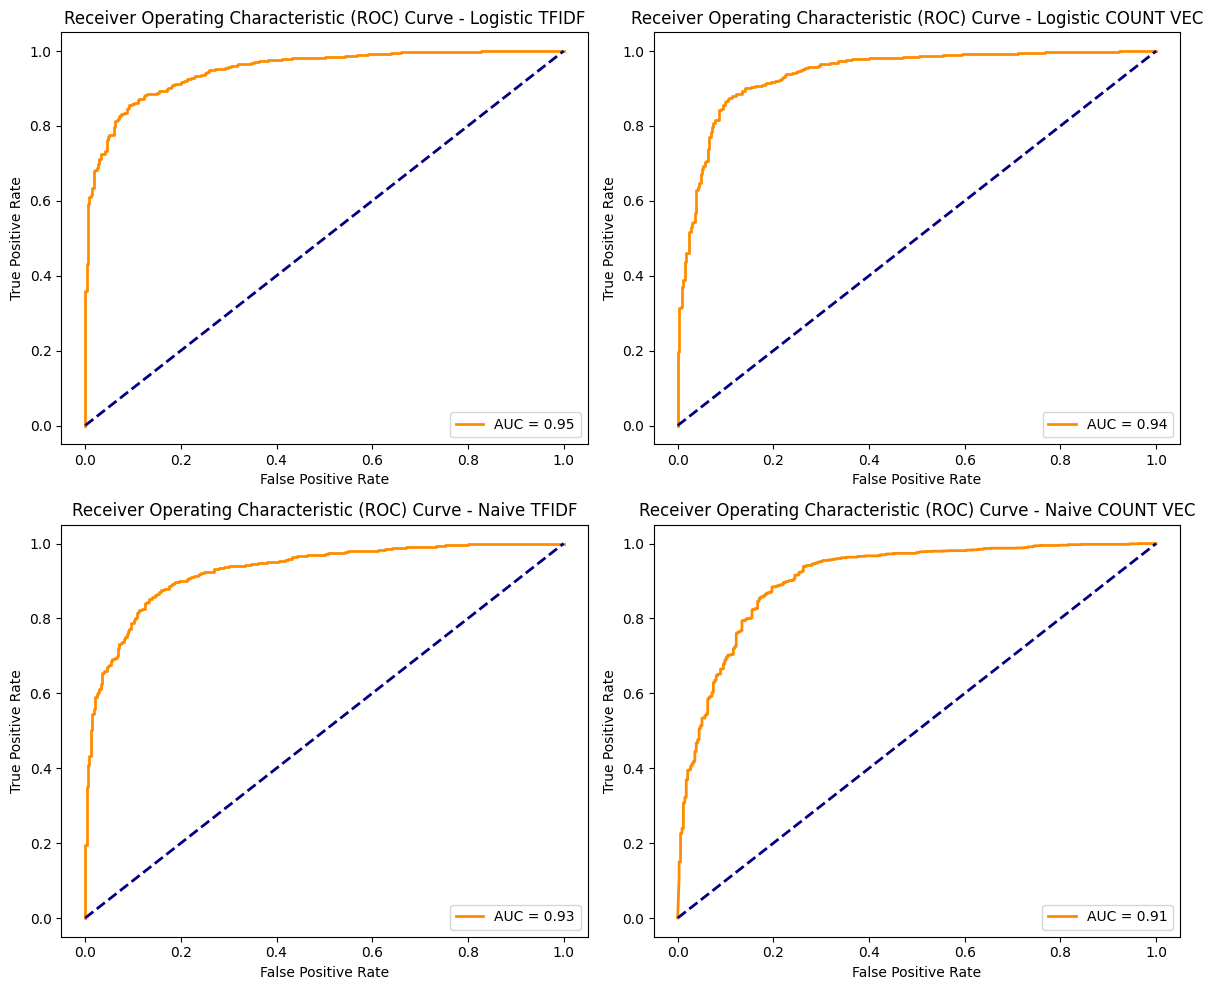

In [25]:

# Supongamos que ya tienes los pipelines y los datos de prueba listos

# Lista de pipelines
pipelines = [pipeline_logistic_TFIDF, pipeline_logistic_COUNT_VEC, pipeline_naive_TFIDF, pipeline_naive_COUNT_VEC]

# Lista de etiquetas para cada gráfico
labels = ['Logistic TFIDF', 'Logistic COUNT VEC', 'Naive TFIDF', 'Naive COUNT VEC']

# Crear una figura de 2x2 para mostrar los gráficos ROC
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Asegúrate de tener datos de prueba (X_test, y_test) listos

for i, (pipeline, label) in enumerate(zip(pipelines, labels)):
    # Calcular las probabilidades
    y_probs = pipeline.predict_proba(X_test)[:, 1]

    # Calcular la curva ROC y el área bajo la curva (AUC)
    fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label='positive')
    roc_auc = auc(fpr, tpr)

    # Configurar el gráfico ROC en el subgráfico correspondiente
    ax = axes[i//2, i%2]
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver Operating Characteristic (ROC) Curve - {label}')
    ax.legend(loc='lower right')

# Ajustar el espaciado
plt.tight_layout()
plt.show()


# Conclusión

# El que mejor funciona:

# **pipeline_logistic_COUNT_VEC**

**Vamos a hacer 6 Predicciónes:**

In [26]:
X_train = pd.DataFrame(X_train)

p_dfh2g = [X_train.iloc[0]['text']]
p_dfh3g = [X_train.iloc[1]['text']]
p_dfh4g = [X_train.iloc[2]['text']]
p_dfn2g = [X_train.iloc[3]['text']]
p_dfn3g = [X_train.iloc[4]['text']]
p_dfn4g = [X_train.iloc[5]['text']]

# Convierte a array de una dimensión (si es necesario)
p_dfh2g = np.array(p_dfh2g)
p_dfh3g = np.array(p_dfh3g)
p_dfh4g = np.array(p_dfh4g)
p_dfn2g = np.array(p_dfn2g)
p_dfn3g = np.array(p_dfn3g)
p_dfn4g = np.array(p_dfn4g)

# Realiza las predicciones
y_dfh2g_pred = pipeline_logistic_COUNT_VEC.predict(p_dfh2g)
y_dfh3g_pred = pipeline_logistic_COUNT_VEC.predict(p_dfh3g)
y_dfh4g_pred = pipeline_logistic_COUNT_VEC.predict(p_dfh4g)
y_dfn2g_pred = pipeline_logistic_COUNT_VEC.predict(p_dfn2g)
y_dfn3g_pred = pipeline_logistic_COUNT_VEC.predict(p_dfn3g)
y_dfn4g_pred = pipeline_logistic_COUNT_VEC.predict(p_dfn4g)

# Imprime los resultados
print('Predicción 1 -> ', p_dfh2g, ' -> ', y_dfh2g_pred)
print('Predicción 2 -> ', p_dfh3g, ' -> ', y_dfh3g_pred)
print('Predicción 3 -> ', p_dfh4g, ' -> ', y_dfh4g_pred)
print('Predicción 4 -> ', p_dfn2g, ' -> ', y_dfn2g_pred)
print('Predicción 5 -> ', p_dfn3g, ' -> ', y_dfn3g_pred)
print('Predicción 6 -> ', p_dfn4g, ' -> ', y_dfn4g_pred)


Predicción 1 ->  ['I indulged big time at Indulge Burgers & More during Fat Tuesday yesterday.  There are a tremendous variety, including many healthy options such as a turkey or veggie burger.  The best part I like is that you can build your own burger with all sorts of yummy toppings.  I had the turkey burger, and the turkey was one of the best I have ever tasted.  Sometimes you can taste like of the darker meats and fatty parts, but I felt like this burger was very clean and lean.  I would highly recommend the sweet potatoe fries that you can order.  You can deep those fries in what tastes like a warm marshamallow dip.   The price is not too bad either for what I call a luxury burger.']  ->  ['positive']
Predicción 2 ->  ["I feel like an East Coast gangster when I roll up to LGO for breakfast. I'll take the Jersey Girl... pump fist and hair toss!! Hands down, it's the BEST omelette I've EVER had. And the fresh-squeezed OJ hits the spot. \n\nAfter a hike at Camelback, it's relaxing t